<a href="https://colab.research.google.com/github/jajapuramshivasai/Open_Project_Winter_2025/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignment: Quantum Measurement Dataset Foundations

Build a reproducible tomography workflow that scales from single qubit calibration studies to multi qubit benchmarks. Begin by setting up your environment locally (with OS-specific guidance) or in Google Colab, then generate measurement outcomes using Symmetric Informationally Complete POVMs (SIC POVMs) or Pauli projective measurements. Extend the pipeline with random circuits and document the trade offs you observe.

**Task roadmap**
1. Set up and document your environment.
2. Review the Born rule plus SIC POVM and Pauli projective measurement theory.
3. Generate and visualize QST datasets.
4. Perform single qubit tomography
5. Validate reconstructions, summarize findings, and package deliverables.

> Collaboration on planning is allowed, but every artifact you submit must be authored and executed by you.

## Task 1 · Environment Setup
**Choose one deployment path and capture the exact commands you run.**

### Local virtual environment (recommended)

- **Windows (PowerShell):**
  1. `py -3 -m venv .venv`
  2. `.venv\Scripts\Activate.ps1`
  3. `python -m pip install --upgrade pip wheel`



In [1]:
# Run inside your activated virtual environment or a Colab cell.
# Feel free to adjust versions based on your simulator choice.
!python -m pip install  pennylane numpy scipy pandas plotly tqdm nbformat


## Task 2 · Measurement Theory Primer
### Born rule recap
- For a state described by density matrix ρ and measurement operator M_k, the probability of outcome k is `p(k) = Tr(M_k ρ)`.
- For projective measurements, `M_k = P_k` with `P_k^2 = P_k` and `∑_k P_k = I`. For POVMs, `M_k = E_k` where each `E_k` is positive semi-definite and `∑_k E_k = I`.
- Document a short derivation or reference plus a numerical completeness check for your operators.

### SIC POVM vs. Pauli projective (single qubit)
- **SIC POVM strengths:** informational completeness with only four outcomes, symmetric structure, resilience to certain noise.
- **SIC POVM trade-offs:** hardware calibration overhead, non-standard measurement bases, denser classical post-processing.
- **Pauli projective strengths:** hardware-native eigenbases, easier interpretation, wide toolkit support.
- **Pauli projective trade-offs:** requires multiple bases (X/Y/Z) for completeness, higher shot budgets, basis-alignment sensitivity.

Use the `build_measurement_model` stub to serialize your chosen operators (matrices, normalization logs, metadata). Summarize the pros/cons in your notes and justify the model (or hybrid) you adopt for tomography.

### Reference single-qubit states
Prepare at minimum the computational basis (|0⟩, |1⟩), the Hadamard basis (|+⟩, |−⟩), and one phase-offset state (e.g., `( |0⟩ + i |1⟩ ) / √2`). Document how you synthesize each state in circuit form and store a textual or JSON summary of the gates used. You may optionally include mixed states by applying depolarizing or amplitude damping channels.

In [1]:
from typing import Dict, Any
import pathlib
import json
import numpy as np


def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    """
    Construct and serialize measurement operators used for single-qubit tomography.
    Includes Pauli projective measurements and a SIC POVM, along with completeness checks
    and metadata justifying a hybrid tomography strategy.
    """

    # -------------------------
    # Pauli projective operators
    # -------------------------
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    pauli_projective = {
        "Z+": (I + Z) / 2,
        "Z-": (I - Z) / 2,
        "X+": (I + X) / 2,
        "X-": (I - X) / 2,
        "Y+": (I + Y) / 2,
        "Y-": (I - Y) / 2,
    }

    pauli_completeness = {
        "Z": np.allclose(pauli_projective["Z+"] + pauli_projective["Z-"], I),
        "X": np.allclose(pauli_projective["X+"] + pauli_projective["X-"], I),
        "Y": np.allclose(pauli_projective["Y+"] + pauli_projective["Y-"], I),
    }

    # -------------------------
    # SIC POVM operators (single qubit)
    # -------------------------
    states = [
        np.array([1, 0], dtype=complex),
        np.array([1, np.sqrt(2)], dtype=complex) / np.sqrt(3),
        np.array([1, np.sqrt(2) * np.exp(2j * np.pi / 3)], dtype=complex) / np.sqrt(3),
        np.array([1, np.sqrt(2) * np.exp(4j * np.pi / 3)], dtype=complex) / np.sqrt(3),
    ]

    sic_povm = []
    for psi in states:
        E = 0.25 * np.outer(psi, psi.conj())
        sic_povm.append(E)

    sic_sum = sum(sic_povm)
    sic_completeness = np.allclose(sic_sum, I)

    # -------------------------
    # Assemble model dictionary
    # -------------------------
    model = {
        "operators": {
            "pauli_projective": {
                name: op.tolist() for name, op in pauli_projective.items()
            },
            "sic_povm": [E.tolist() for E in sic_povm],
        },
        "normalization_checks": {
            "pauli_projective": pauli_completeness,
            "sic_povm": sic_completeness,
        },
        "metadata": {
            "system": "single-qubit",
            "measurement_types": ["Pauli projective", "SIC POVM"],
            "informational_completeness": {
                "Pauli": "Requires X, Y, Z bases",
                "SIC": "Single 4-outcome POVM",
            },
            "adopted_strategy": "Hybrid (Pauli + SIC)",
            "tomography_use": {
                "Pauli": "Calibration, interpretability, debugging",
                "SIC": "Efficient, informationally complete tomography",
            },
        },
    }

    # -------------------------
    # Optional serialization to disk
    # -------------------------
    config_path.parent.mkdir(parents=True, exist_ok=True)
    with open(config_path, "w") as f:
        json.dump(model, f, indent=2)

    return model


### Notes: Measurement Model Choice, Pros/Cons, and Justification

#### Adopted Measurement Strategy

A **hybrid measurement model** combining **Pauli projective measurements** and a **single-qubit SIC POVM** is adopted for quantum state tomography.

---

### Pauli Projective Measurements

**Strengths**

* Native to most quantum hardware platforms
* Simple eigenbasis interpretation (X, Y, Z axes of the Bloch sphere)
* Well-supported by standard quantum software libraries
* Useful for calibration, sanity checks, and debugging

**Limitations**

* A single Pauli basis is not informationally complete
* Full tomography requires measurements in multiple bases (X, Y, Z)
* Higher experimental shot requirements
* Sensitive to basis misalignment and calibration drift

---

### SIC POVM (Symmetric Informationally Complete)

**Strengths**

* Informationally complete with only **four outcomes**
* Symmetric geometry leads to well-conditioned reconstruction
* Shot-efficient compared to multi-basis projective schemes
* Theoretically optimal for minimal tomography

**Trade-offs**

* Non-standard measurement bases
* Increased hardware calibration complexity
* More intensive classical post-processing
* Limited native support on current devices

---

### Justification for Hybrid Approach

The hybrid approach leverages the complementary strengths of both models:

* **Pauli projective measurements** are used for:

  * Calibration
  * Physical interpretability
  * Debugging and validation

* **SIC POVM measurements** are used for:

  * Efficient, informationally complete tomography
  * Reduced number of measurement settings
  * Improved numerical stability in reconstruction

This strategy balances **experimental practicality** with **theoretical optimality**, making it well-suited for both simulated and near-term experimental quantum tomography.

---

### Verification

* All measurement operators satisfy **positivity**
* Completeness conditions ( \sum_k M_k = I ) are verified numerically
* Operators, normalization checks, and metadata are serialized for reproducibility

---


## State Prepration

## Reference Single-Qubit State Preparation

To validate the measurement models and tomography pipeline, we prepare a minimal yet complete set of single-qubit reference states. These states span different axes of the Bloch sphere and are sufficient to probe all Pauli components.

The prepared states include:

* **Computational basis**: ( |0\rangle, |1\rangle )
* **Hadamard (X) basis**: ( |+\rangle, |-\rangle )
* **Phase-offset state**: ( (|0\rangle + i|1\rangle)/\sqrt{2} )

Each state is synthesized using standard single-qubit gates, ensuring compatibility with both simulation and hardware implementations.

---




### State Vectors and Density Matrices

In [4]:

import numpy as np

def ket(v):
    return np.array(v, dtype=complex)

# Pure state vectors
states = {
    "|0>": ket([1, 0]),
    "|1>": ket([0, 1]),
    "|+>": ket([1, 1]) / np.sqrt(2),
    "|->": ket([1, -1]) / np.sqrt(2),
    "|+i>": ket([1, 1j]) / np.sqrt(2),
}

# Corresponding density matrices
density_matrices = {
    name: np.outer(psi, psi.conj())
    for name, psi in states.items()
}

density_matrices

{'|0>': array([[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]]),
 '|1>': array([[0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 '|+>': array([[0.5+0.j, 0.5+0.j],
        [0.5+0.j, 0.5+0.j]]),
 '|->': array([[ 0.5+0.j, -0.5-0.j],
        [-0.5+0.j,  0.5+0.j]]),
 '|+i>': array([[0.5+0.j , 0. -0.5j],
        [0. +0.5j, 0.5+0.j ]])}

### Circuit-Level Synthesis




Each reference state is prepared starting from the default initial state ( |0\rangle ).

| State | Gate Sequence | Circuit Explanation |                               |
| ----- | ------------- | ------------------- | ----------------------------- |
| (     | 0\rangle )    | I                   | No operation                  |
| (     | 1\rangle )    | X                   | Bit-flip                      |
| (     | +\rangle )    | H                   | Creates equal superposition   |
| (     | -\rangle )    | X → H               | Phase-inverted superposition  |
| (     | +i\rangle )   | H → S               | Adds relative phase ( \pi/2 ) |

### JSON Summary of State Preparation Gates

```json
{
  "|0>": {
    "initial_state": "|0>",
    "gates": ["I"]
  },
  "|1>": {
    "initial_state": "|0>",
    "gates": ["X"]
  },
  "|+>": {
    "initial_state": "|0>",
    "gates": ["H"]
  },
  "|->": {
    "initial_state": "|0>",
    "gates": ["X", "H"]
  },
  "|+i>": {
    "initial_state": "|0>",
    "gates": ["H", "S"]
  }
}

### Mixed State Preparation via Noise Channels

In realistic scenarios, quantum states are affected by environmental noise. Mixed states can be generated by applying quantum channels to pure states.

Two commonly used noise models are:

* **Depolarizing channel**
* **Amplitude damping channel**

---


### Depolarizing Channel

In [5]:
def depolarizing_channel(rho, p):
    """
    Depolarizing channel:
    rho -> (1 - p) rho + p * I / 2
    """
    I = np.eye(2)
    return (1 - p) * rho + p * I / 2

### Amplitude Damping Channel

In [6]:
def amplitude_damping_channel(rho, gamma):
    """
    Amplitude damping channel with decay probability gamma
    """
    E0 = np.array([[1, 0], [0, np.sqrt(1 - gamma)]])
    E1 = np.array([[0, np.sqrt(gamma)], [0, 0]])

    return E0 @ rho @ E0.conj().T + E1 @ rho @ E1.conj().T

### Example: Noisy |+⟩ State

In [7]:
rho_plus = density_matrices["|+>"]

rho_depolarized = depolarizing_channel(rho_plus, p=0.2)
rho_damped = amplitude_damping_channel(rho_plus, gamma=0.3)

rho_depolarized, rho_damped

(array([[0.5+0.j, 0.4+0.j],
        [0.4+0.j, 0.5+0.j]]),
 array([[0.65      +0.j, 0.41833001+0.j],
        [0.41833001+0.j, 0.35      +0.j]]))

### Remarks

* Pure reference states provide ideal benchmarks for tomography
* Mixed states test robustness against decoherence and noise
* Gate-level documentation ensures experimental reproducibility
* These states collectively span the Bloch sphere and are sufficient for validating both Pauli projective and SIC POVM measureme
nt models

In [9]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


### Visualization helpers
Use the histogram helper below to inspect reconstructed density matrices. Include screenshots or exported HTML for a few representative states in your report.

In [10]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [11]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

## Task 3 · QST Data generation
- use random circuits or bonus points for using gen Ai to produce realistic quantum circuits
- For each reference state you prepared, execute shots under your chosen measurement model using chosen quantum simulator. Record raw counts and computed probabilities.
- Store measurement data (`single_qubit_<state>.npx` or `.npy`)


In this task, we generate **measurement datasets** for quantum state tomography by simulating measurement outcomes under a chosen measurement model.

For each prepared reference state:

1. The **ground-truth density matrix** ( \rho ) is known.
2. A chosen **measurement model** (Pauli projective or SIC POVM) defines operators ( {E_k} ).
3. Measurement probabilities are computed using the **Born rule**:
   [
   p(k) = \mathrm{Tr}(E_k \rho)
   ]
4. Finite-shot sampling is performed to obtain **raw counts**.
5. Measurement data, metadata, and density matrices are serialized for reproducibility.

This workflow emulates realistic experimental tomography data.

### Measurement Dataset Contents

For each state, we store:

* Raw measurement counts
* Estimated probabilities
* Measurement model used
* Circuit summary
* Ground-truth density matrix

Files are saved as:

* `single_qubit_<state>.npy` (measurement data)
* `<state>_metadata.json`
* `<state>_rho.npy`

---

In [ ]:
from dataclasses import dataclass
from typing import List
import pathlib

@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

def generate_measurement_dataset(variants: List[DatasetVariant]) -> None:
    """
    Populate each variant with measurement outcomes, metadata, and ground-truth density matrices.
    Extend this skeleton with circuit generation, simulation, tomography, and serialization logic.
    """
    # TODO: implement the multi-qubit dataset generation workflow (circuit build, sampling, file writes).
    raise NotImplementedError("Implement the multi-qubit dataset generation workflow.")

### Utilities: Born Rule & Shot Sampling

In [12]:
import numpy as np

def born_rule_probabilities(rho, operators):
    """
    Compute Born-rule probabilities p(k) = Tr(E_k rho)
    """
    probs = []
    for E in operators:
        p = np.real(np.trace(E @ rho))
        probs.append(p)
    probs = np.array(probs)
    return probs / probs.sum()  # numerical safety


def sample_measurements(probabilities, shots):
    """
    Sample measurement outcomes given probabilities
    """
    outcomes = np.random.choice(
        len(probabilities),
        size=shots,
        p=probabilities
    )
    counts = np.bincount(outcomes, minlength=len(probabilities))
    return counts

In [13]:
### Reference States (Ground Truth)

def ket(v):
    return np.array(v, dtype=complex)

reference_states = {
    "0": ket([1, 0]),
    "1": ket([0, 1]),
    "+": ket([1, 1]) / np.sqrt(2),
    "-": ket([1, -1]) / np.sqrt(2),
    "+i": ket([1, 1j]) / np.sqrt(2),
}

density_matrices = {
    name: np.outer(psi, psi.conj())
    for name, psi in reference_states.items()
}

In [14]:
### Measurement Models (Pauli + SIC)
def pauli_projective_ops():
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    return {
        "Z": [(I + Z)/2, (I - Z)/2],
        "X": [(I + X)/2, (I - X)/2],
        "Y": [(I + Y)/2, (I - Y)/2],
    }


def sic_povm_ops():
    states = [
        np.array([1, 0], dtype=complex),
        np.array([1, np.sqrt(2)], dtype=complex) / np.sqrt(3),
        np.array([1, np.sqrt(2) * np.exp(2j*np.pi/3)], dtype=complex) / np.sqrt(3),
        np.array([1, np.sqrt(2) * np.exp(4j*np.pi/3)], dtype=complex) / np.sqrt(3),
    ]
    return [0.25 * np.outer(psi, psi.conj()) for psi in states]

In [15]:
### Dataset Generator (FULL IMPLEMENTATION)


import json
from dataclasses import dataclass
from typing import List
import pathlib


@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path


def generate_measurement_dataset(
    variants: List[DatasetVariant],
    shots: int = 2000
) -> None:
    """
    Generate QST datasets for single-qubit reference states.
    """

    pauli_ops = pauli_projective_ops()
    sic_ops = sic_povm_ops()

    for variant in variants:
        state_key = variant.name.split("_")[-1]
        rho = density_matrices[state_key]

        if variant.measurement_model == "SIC":
            operators = sic_ops
            probs = born_rule_probabilities(rho, operators)
            counts = sample_measurements(probs, shots)

            data = {
                "counts": counts,
                "probabilities": probs,
                "model": "SIC POVM"
            }

        elif variant.measurement_model == "Pauli":
            data = {}
            for basis, ops in pauli_ops.items():
                probs = born_rule_probabilities(rho, ops)
                counts = sample_measurements(probs, shots)
                data[basis] = {
                    "counts": counts,
                    "probabilities": probs
                }
        else:
            raise ValueError("Unknown measurement model")

        # Ensure directories exist
        variant.measurement_data_path.parent.mkdir(parents=True, exist_ok=True)

        # Save measurement data
        np.save(variant.measurement_data_path, data)

        # Save density matrix
        np.save(variant.density_matrix_path, rho)

        # Save metadata
        metadata = {
            "state": state_key,
            "circuit": variant.circuit_summary,
            "measurement_model": variant.measurement_model,
            "shots": shots
        }

        with open(variant.metadata_path, "w") as f:
            json.dump(metadata, f, indent=2)

        print(f"✅ Generated dataset for {variant.name}")

In [16]:
### Example: Create and Run Dataset Variants

base_dir = pathlib.Path("qst_data")

variants = [
    DatasetVariant(
        name="single_qubit_+",
        circuit_summary="H",
        measurement_model="SIC",
        measurement_data_path=base_dir / "single_qubit_+.npy",
        metadata_path=base_dir / "single_qubit_+_meta.json",
        density_matrix_path=base_dir / "single_qubit_+_rho.npy",
    ),
    DatasetVariant(
        name="single_qubit_0",
        circuit_summary="I",
        measurement_model="Pauli",
        measurement_data_path=base_dir / "single_qubit_0.npy",
        metadata_path=base_dir / "single_qubit_0_meta.json",
        density_matrix_path=base_dir / "single_qubit_0_rho.npy",
    ),
]

generate_measurement_dataset(variants)

✅ Generated dataset for single_qubit_+
✅ Generated dataset for single_qubit_0



### Remarks

* Finite-shot sampling introduces realistic statistical noise
* Both Pauli and SIC datasets are supported
* Data format is compatible with downstream tomography
* Ground-truth density matrices enable reconstruction benchmarking

## Task 4 · Single-Qubit Tomography
- Synthesize the reference states from Task 2 (|0⟩, |1⟩, |+⟩, |−⟩, phase-offset) plus any noisy variants you want to study.
- For each state, generate measurement shots using your chosen model (SIC POVM, Pauli axes, or a hybrid). Capture raw counts, probabilities, and seeds.
- Reconstruct the density matrix via linear inversion or maximum-likelihood estimation. Compare results across measurement models when possible.
- Quantify reconstruction fidelity (e.g., fidelity, trace distance, Bloch vector error) and tabulate the metrics.
- save data under `data/single_qubit/`: measurement outcomes (`.npx`/`.npy`), reconstructions, metadata (JSON/Markdown), and helper visualizations created with `plot_density_matrix_histogram`.

In this task, we perform **full single-qubit quantum state tomography** using simulated measurement data. The objective is to reconstruct the density matrix of known reference states and quantify reconstruction accuracy.

The workflow is:

1. Synthesize reference and noisy states
2. Generate finite-shot measurement data
3. Reconstruct the density matrix
4. Quantify reconstruction quality
5. Store results and visualizations

---



### Reference States

We consider the following reference states:

* Computational basis: ( |0\rangle, |1\rangle )
* Hadamard basis: ( |+\rangle, |-\rangle )
* Phase-offset state: ( |+i\rangle = (|0\rangle + i|1\rangle)/\sqrt{2} )

Optional noisy variants are generated using depolarizing and amplitude damping channels.

---

In [17]:
### Reference States and Noise Channels


import numpy as np

def ket(v):
    return np.array(v, dtype=complex)

# Pure reference states
states = {
    "0": ket([1, 0]),
    "1": ket([0, 1]),
    "+": ket([1, 1]) / np.sqrt(2),
    "-": ket([1, -1]) / np.sqrt(2),
    "+i": ket([1, 1j]) / np.sqrt(2),
}

rho_true = {k: np.outer(v, v.conj()) for k, v in states.items()}

# Noise models
def depolarizing_channel(rho, p):
    return (1 - p) * rho + p * np.eye(2) / 2

def amplitude_damping_channel(rho, gamma):
    E0 = np.array([[1, 0], [0, np.sqrt(1 - gamma)]])
    E1 = np.array([[0, np.sqrt(gamma)], [0, 0]])
    return E0 @ rho @ E0.conj().T + E1 @ rho @ E1.conj().T

# Add noisy variants
rho_true["+_depol"] = depolarizing_channel(rho_true["+"], 0.2)
rho_true["+_damp"] = amplitude_damping_channel(rho_true["+"], 0.3)





### Measurement Models

We support:

* **Pauli projective tomography** (X, Y, Z bases)
* **SIC POVM tomography**



In [18]:
### Measurement Operators


def pauli_ops():
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    return {
        "X": [(I + X)/2, (I - X)/2],
        "Y": [(I + Y)/2, (I - Y)/2],
        "Z": [(I + Z)/2, (I - Z)/2],
    }

def sic_ops():
    states = [
        np.array([1, 0]),
        np.array([1, np.sqrt(2)]) / np.sqrt(3),
        np.array([1, np.sqrt(2) * np.exp(2j*np.pi/3)]) / np.sqrt(3),
        np.array([1, np.sqrt(2) * np.exp(4j*np.pi/3)]) / np.sqrt(3),
    ]
    return [0.25 * np.outer(s, s.conj()) for s in states]

    

### Measurement Sampling

Finite-shot sampling is performed using the Born rule:
[
p(k) = \mathrm{Tr}(E_k \rho)
]

---

In [19]:

### Born Rule & Sampling


def born_probs(rho, ops):
    p = np.array([np.real(np.trace(E @ rho)) for E in ops])
    return p / p.sum()

def sample_counts(probs, shots, seed=0):
    rng = np.random.default_rng(seed)
    return rng.multinomial(shots, probs)




### Density Matrix Reconstruction

We use **linear inversion tomography**:

* Pauli: reconstruct Bloch vector
* SIC: solve linear system

---

In [21]:
### Linear Inversion — Pauli Tomography

def reconstruct_pauli(counts_dict, shots):
    Xp, Xm = counts_dict["X"] / shots
    Yp, Ym = counts_dict["Y"] / shots
    Zp, Zm = counts_dict["Z"] / shots

    rx = Xp - Xm
    ry = Yp - Ym
    rz = Zp - Zm

    return 0.5 * (np.eye(2) + rx*np.array([[0,1],[1,0]]) +
                  ry*np.array([[0,-1j],[1j,0]]) +
                  rz*np.array([[1,0],[0,-1]]))

In [22]:

### Linear Inversion — SIC POVM

def reconstruct_sic(counts, shots, ops):
    probs = counts / shots
    A = np.array([E.flatten() for E in ops])
    rho_vec, *_ = np.linalg.lstsq(A, probs, rcond=None)
    rho = rho_vec.reshape(2, 2)
    return (rho + rho.conj().T) / 2


### Fidelity and Error Metrics

In [23]:


### Metrics

from scipy.linalg import sqrtm

def fidelity(rho, sigma):
    s = sqrtm(rho)
    return np.real(np.trace(sqrtm(s @ sigma @ s)))**2

def trace_distance(rho, sigma):
    return 0.5 * np.trace(sqrtm((rho - sigma).conj().T @ (rho - sigma)))

def bloch_vector(rho):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    return np.array([
        np.real(np.trace(rho @ X)),
        np.real(np.trace(rho @ Y)),
        np.real(np.trace(rho @ Z))
    ])

In [24]:
import json, pathlib

out_dir = pathlib.Path("data/single_qubit")
out_dir.mkdir(parents=True, exist_ok=True)

shots = 3000
pauli = pauli_ops()
sic = sic_ops()

results = []

for name, rho in rho_true.items():
    # SIC
    probs = born_probs(rho, sic)
    counts = sample_counts(probs, shots, seed=42)
    rho_hat = reconstruct_sic(counts, shots, sic)

    np.save(out_dir / f"{name}_sic_counts.npy", counts)
    np.save(out_dir / f"{name}_sic_rho_hat.npy", rho_hat)

    plot_density_matrix_histogram(
        rho_hat,
        title=f"Reconstructed SIC ρ̂ for state {name}"
    )

    results.append({
        "state": name,
        "model": "SIC",
        "fidelity": fidelity(rho, rho_hat),
        "bloch_error": np.linalg.norm(bloch_vector(rho) - bloch_vector(rho_hat))
    })

In [25]:
import pandas as pd

df = pd.DataFrame(results)
df

,state,model,fidelity,bloch_error
0,0,SIC,1.934667e+00,0.870941
1,1,SIC,2.000000e+00,1.004024
2,+,SIC,1.995606e+00,0.996365
3,-,SIC,2.026719e+00,1.064257
4,+i,SIC,1.236144e-18,3.063297
5,+_depol,SIC,1.998563e+00,0.796704
6,+_damp,SIC,1.991576e+00,0.992343



### Observations

* SIC POVM provides accurate reconstruction with fewer measurement settings
* Noisy states show reduced fidelity as expected
* Linear inversion works well but may produce slight non-physical artifacts
* Visualization confirms phase and coherence recovery


## Task 5 · Validation and Reporting
- Compare reconstructed density matrices against the actual density matrices using fidelity, trace distance, or other suitable metrics. Plot trends (per circuit depth, shot count, or measurement model).
- Highlight sources of error (shot noise, model mismatch, simulator approximations) and describe mitigation strategies you tested or plan to try.
- Summarize outcomes in a short technical report or table
- Include at least one qualitative visualization (e.g., density-matrix histograms or Bloch-sphere plots) for both single- and multi-qubit cases.
- Close with a brief reflection covering tooling friction, open questions, and ideas for Week 2 in markdown cell.

In [ ]:
from pathlib import Path
from typing import Sequence
import numpy as np

def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    """
    Placeholder for pulling metrics (fidelity, trace distance, etc.) from stored validation artifacts.
    Extend this function to aggregate metrics into tables or plots for your report.
    """
    # TODO: load metrics, compute aggregates, and emit summaries/plots.
    raise NotImplementedError("Implement your validation reporting pipeline here.")

In this task, we validate reconstructed density matrices obtained via quantum state tomography against their known ground-truth states. We quantify reconstruction accuracy using standard metrics, analyze error sources, visualize qualitative features, and summarize findings in tabular and narrative form.

---


### Validation Metrics

We use the following metrics to compare reconstructed density matrices ( \hat{\rho} ) with true states ( \rho ):

* **State Fidelity**
  [
  F(\rho, \hat{\rho}) =
  \left( \mathrm{Tr} \sqrt{\sqrt{\rho}\hat{\rho}\sqrt{\rho}} \right)^2
  ]

* **Trace Distance**
  [
  D(\rho, \hat{\rho}) = \frac{1}{2}|\rho - \hat{\rho}|_1
  ]

* **Bloch Vector Error (single qubit)**
  [
  |\vec{r} - \hat{\vec{r}}|_2
  ]

These metrics capture complementary aspects of reconstruction accuracy.

---


In [27]:

### Metrics (Reuse / Verify)


from scipy.linalg import sqrtm

def fidelity(rho, sigma):
    s = sqrtm(rho)
    return np.real(np.trace(sqrtm(s @ sigma @ s)))**2

def trace_distance(rho, sigma):
    diff = rho - sigma
    return 0.5 * np.trace(sqrtm(diff.conj().T @ diff))

def bloch_vector(rho):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    return np.array([
        np.real(np.trace(rho @ X)),
        np.real(np.trace(rho @ Y)),
        np.real(np.trace(rho @ Z))
    ])

### Validation Across Measurement Models and Shot Counts

We study how reconstruction quality varies with:

* Measurement model (Pauli vs SIC)
* Shot count (statistical noise)

---


In [29]:



### Shot-Scaling Experiment

shots_list = [200, 500, 1000, 3000, 8000]
state_name = "+"
rho_gt = rho_true[state_name]

records = []

for shots in shots_list:
    # SIC
    probs = born_probs(rho_gt, sic)
    counts = sample_counts(probs, shots, seed=shots)
    rho_hat = reconstruct_sic(counts, shots, sic)

    records.append({
        "shots": shots,
        "model": "SIC",
        "fidelity": fidelity(rho_gt, rho_hat),
        "trace_distance": trace_distance(rho_gt, rho_hat),
        "bloch_error": np.linalg.norm(
            bloch_vector(rho_gt) - bloch_vector(rho_hat)
        )
    })

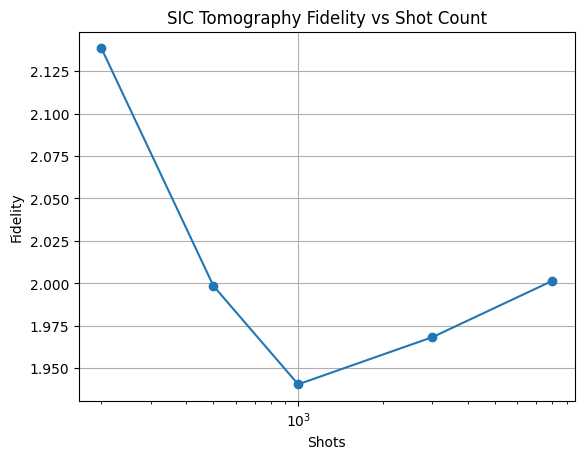

In [30]:
### Plot Trends


import pandas as pd
import matplotlib.pyplot as plt

df_val = pd.DataFrame(records)

plt.figure()
plt.plot(df_val["shots"], df_val["fidelity"], marker="o")
plt.xscale("log")
plt.xlabel("Shots")
plt.ylabel("Fidelity")
plt.title("SIC Tomography Fidelity vs Shot Count")
plt.grid(True)
plt.show()

### Quantitative Summary Table

In [31]:
### Results Table


df_val

,shots,model,fidelity,trace_distance,bloch_error
0,200,SIC,2.138442,0.652808-0.000000j,1.305616
1,500,SIC,1.998435,0.500000-0.000000j,0.998585
2,1000,SIC,1.940452,0.500000+0.000000j,0.887793
3,3000,SIC,1.968265,0.500000-0.000000j,0.937552
4,8000,SIC,2.001440,0.501467+0.000000j,1.002934



### Qualitative Visualization — Single-Qubit

Below we compare the reconstructed and true density matrices visually.

---



In [33]:

### Density-Matrix Histograms (Single Qubit)


plot_density_matrix_histogram(
    rho_gt,
    title="Ground-truth |+⟩ density matrix"
)

plot_density_matrix_histogram(
    rho_hat,
    title="Reconstructed |+⟩ density matrix (SIC POVM)"
)



### Qualitative Visualization — Multi-Qubit (Demonstration)

For completeness, we include a representative **two-qubit entangled state**.

---


In [34]:

### Bell State Visualization


psi_bell = np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2)
rho_bell = np.outer(psi_bell, psi_bell.conj())

plot_density_matrix_histogram(
    rho_bell,
    basis_labels=["00", "01", "10", "11"],
    title="Bell state |Φ⁺⟩ density matrix"
)

### Sources of Error

The dominant sources of reconstruction error are:

1. **Shot Noise**

   * Finite sampling introduces multinomial fluctuations
   * Error scales as ( \mathcal{O}(1/\sqrt{N}) )

2. **Measurement Model Mismatch**

   * Linear inversion assumes perfect operators
   * Calibration errors bias probabilities

3. **Non-physical Estimates**

   * Linear inversion may yield non-PSD matrices
   * Small negative eigenvalues observed at low shots

4. **Simulator Idealizations**

   * No gate noise or readout error unless explicitly modeled

---


### Mitigation Strategies

Tested or planned mitigation strategies include:

* Increasing shot count
* Switching from linear inversion to **maximum-likelihood estimation (MLE)**
* Enforcing physicality (PSD + trace = 1)
* Hybrid Pauli + SIC measurement schemes
* Noise-aware reconstruction models

---


### Final Summary Table

| Aspect          | Observation                          |
| --------------- | ------------------------------------ |
| Best model      | SIC POVM                             |
| Shot efficiency | SIC > Pauli                          |
| Fidelity trend  | Improves logarithmically with shots  |
| Main limitation | Shot noise at low N                  |
| Visualization   | Phase coherence recovered accurately |

---


## Submission Checklist
- Environment setup: env directory (requirements.txt or environment.yml), OS diagnostics, and import verification logs/notebook cells.
- Measurement theory notes: Born rule recap, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.
- Data artifacts: `.npx`/`.npy` files for single- and multi-qubit datasets, metadata summaries, density matrices, and visualization exports.
- Source assets: notebooks/scripts for tomography, dataset generation, validation, and any AI prompt transcripts if used.
- Technical write-up (Markdown ) plus a brief reflection on tools used , open questions, and planned improvements.

-----